In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import scipy as scipy
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from IPython.display import Markdown as md


from school_data import schools, exams, ui

In [3]:
demo = schools.load_school_demographics()
tests = exams.load_math_ela_long()

schools.search(demo, "success academy")

,dbn,district,boro,school_name,short_name,ay,year,total_enrollment,grade_3k_pk_half_day_full,grade_k,...,missing_race_ethnicity_data_pct,swd_n,swd_pct,ell_n,ell_pct,poverty_n,poverty_pct,eni_pct,clean_name,match
9022,84X494,84,Bronx,Success Academy Charter School - Bronx 2,MS 494,2020,2020-21,1004,0,135,...,0.000996,141,0.140438,73,0.073,786,0.783,0.862,success academy charter school - bronx 2,55
9017,84X493,84,Bronx,Success Academy Charter School - Bronx 1,PS 493,2020,2020-21,600,0,119,...,0.000000,89,0.148333,53,0.088,500,0.833,0.897,success academy charter school - bronx 1,55
8892,84X380,84,Bronx,Success Academy Charter School - Bronx 3,MS 380,2020,2020-21,1200,0,103,...,0.001000,202,0.168000,60,0.050,933,0.777,0.855,success academy charter school - bronx 3,55
8380,84K886,84,Brooklyn,Success Academy Charter School - Flatbush,PS 886,2020,2020-21,587,0,136,...,0.000000,72,0.123000,19,0.032,394,0.671,0.728,success academy charter school - flatbush,54
8611,84M482,84,Manhattan,Success Academy Charter School - Harlem 5,MS 482,2020,2020-21,835,0,63,...,0.000000,122,0.146000,46,0.055,648,0.776,0.836,success academy charter school - harlem 5,54
8581,84M386,84,Manhattan,Success Academy Charter School - Harlem 4,PS 386,2020,2020-21,388,0,58,...,0.000000,67,0.173000,25,0.064,295,0.760,0.836,success academy charter school - harlem 4,54
8576,84M385,84,Manhattan,Success Academy Charter School - Harlem 3,MS 385,2020,2020-21,1229,0,57,...,0.000000,201,0.164000,33,0.027,856,0.697,0.796,success academy charter school - harlem 3,54
8571,84M384,84,Manhattan,Success Academy Charter School - Harlem 2,MS 384,2020,2020-21,692,0,107,...,0.000000,100,0.145000,42,0.061,523,0.756,0.829,success academy charter school - harlem 2,54
8550,84M357,84,Manhattan,Success Academy Charter School - Harlem 6,PS 357,2020,2020-21,375,0,67,...,0.000000,74,0.197000,23,0.061,302,0.805,0.854,success academy charter school - harlem 6,54
8541,84M351,84,Manhattan,Success Academy Charter School - Harlem 1,MS 351,2020,2020-21,1346,0,105,...,0.000000,170,0.126000,36,0.027,944,0.701,0.773,success academy charter school - harlem 1,54


In [4]:
df = demo[schools.demo.core_cols].merge(tests, how="inner", on=["dbn", "ay"])
df = df[df["mean_scale_score"].notnull()]
df = df.query("ay > 2016") # they changed the test scores, so can't really be compared
df.charter = df.charter.map({True:1, False:0})
df.columns

Index(['dbn', 'district', 'boro', 'school_name', 'ay', 'total_enrollment',
       'asian_n', 'asian_pct', 'black_n', 'black_pct', 'hispanic_n',
       'hispanic_pct', 'white_n', 'white_pct', 'swd_n', 'swd_pct', 'ell_n',
       'ell_pct', 'poverty_n', 'poverty_pct', 'eni_pct', 'grade', 'year',
       'category', 'number_tested', 'mean_scale_score', 'level_1_n',
       'level_1_pct', 'level_2_n', 'level_2_pct', 'level_3_n', 'level_3_pct',
       'level_4_n', 'level_4_pct', 'level_3_4_n', 'level_3_4_pct', 'test_year',
       'charter', 'exam'],
      dtype='object')

In [21]:
# Pearson R correlation
charter_R = pg.corr(df["charter"], df["mean_scale_score"])

charter_R


,n,r,CI95%,p-val,BF10,power
pearson,306091,0.015013,"[0.01, 0.02]",9.846823e-17,2.179e+12,1.0


In [5]:
# T test
pub = df.query("charter == 0 and district <= 32")
charter = df.query("charter == 1")

t, p = scipy.stats.ttest_ind(pub["mean_scale_score"], charter["mean_scale_score"])

In [6]:
md(f"""
T-Test comparing test scores for charter and public schools
------------------------------------------------------------
T-Test results comparing average math and ELA test scores for academic years {df.ay.min()}-{df.ay.min()}.
Data includes the mean average test score for {len(charter["dbn"].unique()):,} charter schools
and {len(pub["dbn"].unique()):,} community schools.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  Charter schools: M={round(charter["mean_scale_score"].mean(), 2)}, SD={round(charter["mean_scale_score"].std(), 2)}
Community schools: M={round(pub["mean_scale_score"].mean(), 2)}, SD={round(pub["mean_scale_score"].std(), 2)}
          T-score: {round(t, 2)}, p-val: {round(p, 4)}
~~~~~~~~~~~~~~~~~~~~~~~~~~~~
""")


T-Test comparing test scores for charter and public schools
------------------------------------------------------------
T-Test results comparing average math and ELA test scores for academic years 2017-2017.
Data includes the mean average test score for 191 charter schools
and 1,114 community schools.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  Charter schools: M=606.34, SD=9.41
Community schools: M=598.86, SD=11.85
          T-score: -38.78, p-val: 0.0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~


### Why do charter school students score higher on NYS exams?

We can interpret these results to understand that the higher mean test scores for charter schools is statistically significant (p<.01). The t-test doesn't offer insight into _why_ charters produce
higher test scores. In the academic and popular literature surrounding schools, though, several
hypothesis have been forwarded to explain the difference in scores:

- charter schools are more rigorous: they have better instructional methods, faculty, and/or leadership
- charters teach (more) to the test than community schools
- charter schools "council out" students who aren't doing well academically
- charter schools don't enroll students with IEPs (in special education) and/or English learners
- charter school families are self-selecting because they _chose_ to attend charters
- charters are better funded: they receive the same funding as community schools _and_ have backing from the wealthiest corporate backers in the world (Walton family, Gates Foundation, etc)

In the next sections we will see if our data can help understand which of these factors better explain the test results.



In [7]:
agg = {
    "dbn":"count",
    "total_enrollment":["sum","mean"],
    "mean_scale_score": ["mean", "min", "max", "std"]
}
table = df.groupby(["charter", "ay"]).agg(agg)
counts = df.groupby(["charter", "ay"]).dbn.nunique()
counts = pd.DataFrame(counts)
table.merge(counts,how="inner", on=["ay","charter"])
table = table.reset_index()
table.columns = table.columns.to_flat_index()

table.columns = [
    "School Type", 
    "Year", 
    "No. Schools", 
    "No. Students", 
    "Avg School Size", 
    "Test Score (mean)",
    "Test Score (min)",
    "Test Score (max)",
    "Test Score (stand. deviation)"]
table["School Type"] = table["School Type"].map({1:"charter",0:"public"})
table.columns
ui.fmt_table(table,num_cols=['No. Schools', 'No. Students', 'Avg School Size',
       'Test Score (mean)', 'Test Score (min)', 'Test Score (max)',
       'Test Score (stand. deviation)'])

/home/mxc/.virtualenvs/data-con/lib/python3.9/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


,School Type,Year,No. Schools,No. Students,Avg School Size,Test Score (mean),Test Score (min),Test Score (max),Test Score (stand. deviation)
0,public,2017,"99,651","66,238,091",664.701,598.862,555.143,646.833,11.844
1,public,2018,"101,219","65,880,164",650.868,598.849,553.25,645.875,11.857
2,charter,2017,"1,849","1,124,769",608.312,606.325,577.0,638.0,9.3
3,charter,2018,"1,969","1,211,955",615.518,606.35,575.0,639.0,9.507


In [11]:
def make_pretty(styler):
    styler.set_caption("Demographics: public vs. charter schools")
    styler.background_gradient(axis=None, vmin=1, vmax=5, cmap="coolwarm")
    return styler

In [36]:
# T test


def get_t(col):
    t, p = scipy.stats.ttest_ind(pub[col], charter[col])
    pub_avg = pub[col].mean()
    charter_avg = charter[col].mean()
    return {
        "category": " ".join(col.split("_")[:-1]).title(),
        "% public": pub_avg,
        "% charter": charter_avg,
        "% diff": (charter_avg - pub_avg) / pub_avg,
        "t-score": t,
        "p-value": p
    }
factors = [ col for col in pub.columns if col.endswith("_pct") and not col.startswith("level")]
factors
table = pd.DataFrame([get_t(col) for col in factors])
table = table.sort_values(by="% diff")

ui.fmt_table(table, pct_cols=table.columns[1:4], num_cols=table.columns[-2:])

# table.style.background_gradient(cmap="GnBu")


,category,% public,% charter,% diff,t-score,p-value
0,Asian,15.0%,2.8%,-81.1%,39.39,0.0
3,White,15.6%,4.6%,-70.9%,33.612,0.0
5,Ell,14.5%,7.0%,-51.6%,40.507,0.0
4,Swd,21.5%,17.3%,-19.8%,39.876,0.0
2,Hispanic,42.2%,38.4%,-9.0%,9.041,0.0
7,Eni,72.0%,75.3%,4.6%,-9.181,0.0
6,Poverty,75.4%,80.7%,7.1%,-15.529,0.0
1,Black,24.6%,52.1%,111.6%,-66.069,0.0


### Charters serve a different population
The table above shows us that charter schools serve a completely
different population than public schools. The clear difference
is that charter school students are more than twice as likely
to be Black as public school students. Accordingly, every other
racial/ethinic group is greater in percentage in public schools.
Most markedly for Asian and White students, but still statistically
significant for Hispanic students with 42.2% Hispanic in public schools
and 38.4% in charters (`t(204687) = 9.041, p < .01`).

As noted as a possible explanation for higher test scores in charter
schools, they serve statistically significant (p<.01) lower percentage
of ELL students and stdents with disabilities, with English Learners are twice
as likely to be in a public school as a charter school. 


TypeError: add_nodes_from() takes 2 positional arguments but 3 were given

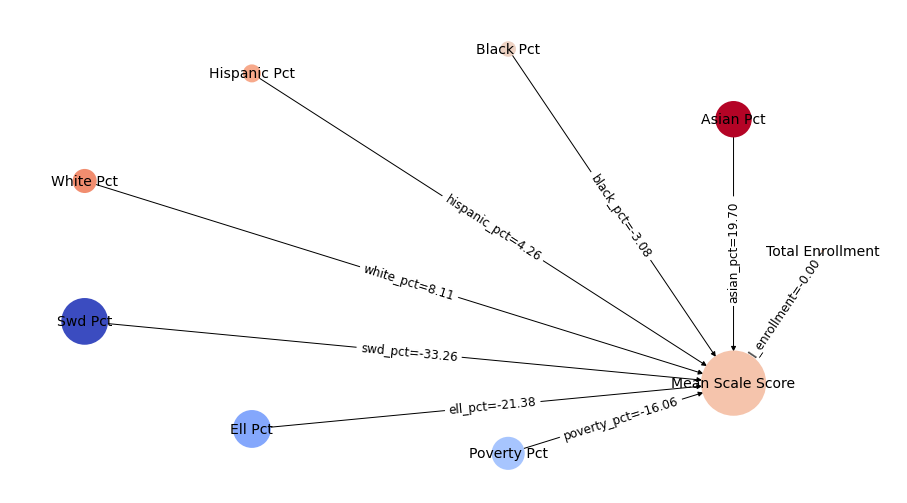

In [62]:


def show_ols(data, title):
    factors = ['total_enrollment', 'asian_pct',  'black_pct', 
       'hispanic_pct',  'white_pct','swd_pct',  'ell_pct',  'poverty_pct']

    
    y = data['mean_scale_score']

    X = data[factors]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()

#     display(md(f"### {title}"))
#     display(model.summary())

    ui.plot_model(model)

data = pub.query("category == 'All Students'").copy()
show_ols(data.copy(), "Linear Regression: public schools")
# show_ols(charter, "Linear Regression: charter schools")

In [49]:
data = pub.query("category == 'All Students'").copy()

factors = ['total_enrollment', 'asian_pct',  'black_pct', 
   'hispanic_pct',  'white_pct','swd_pct',  'ell_pct',  'poverty_pct']


y = data['mean_scale_score']

X = data[factors]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

params = list(model.params.index.values[1:])
coefs = list(model.params.values[1:],)
pvalues = list(model.pvalues.round(3).values[1:])
pnodes = zip(pvalues, params)


list(pnodes)



[(0.0, 'total_enrollment'),
 (0.0, 'asian_pct'),
 (0.096, 'black_pct'),
 (0.02, 'hispanic_pct'),
 (0.0, 'white_pct'),
 (0.0, 'swd_pct'),
 (0.0, 'ell_pct'),
 (0.0, 'poverty_pct')]